# Import Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
import datetime

# Morris Results

In [2]:
# Import data
ages = ['UNDER5', 'AGE517', 'AGE1829', 'AGE4049', 'AGE3039', 'AGE5064', 'AGE6574', 'AGE75PLUS']
morris = 'figures_morris'

data = []
for i in range(len(ages)):
    x = pd.read_csv('./results/' + ages[i] + '/' + morris + '/Morris.csv')
    data.append(x)
     
age_total = []
# Age 
for i in range(len(ages)):
    age_total.append(data[i][data[i].Feature == ages[i]])

# Function for formatter
class OOMFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        mpl.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

## Plot

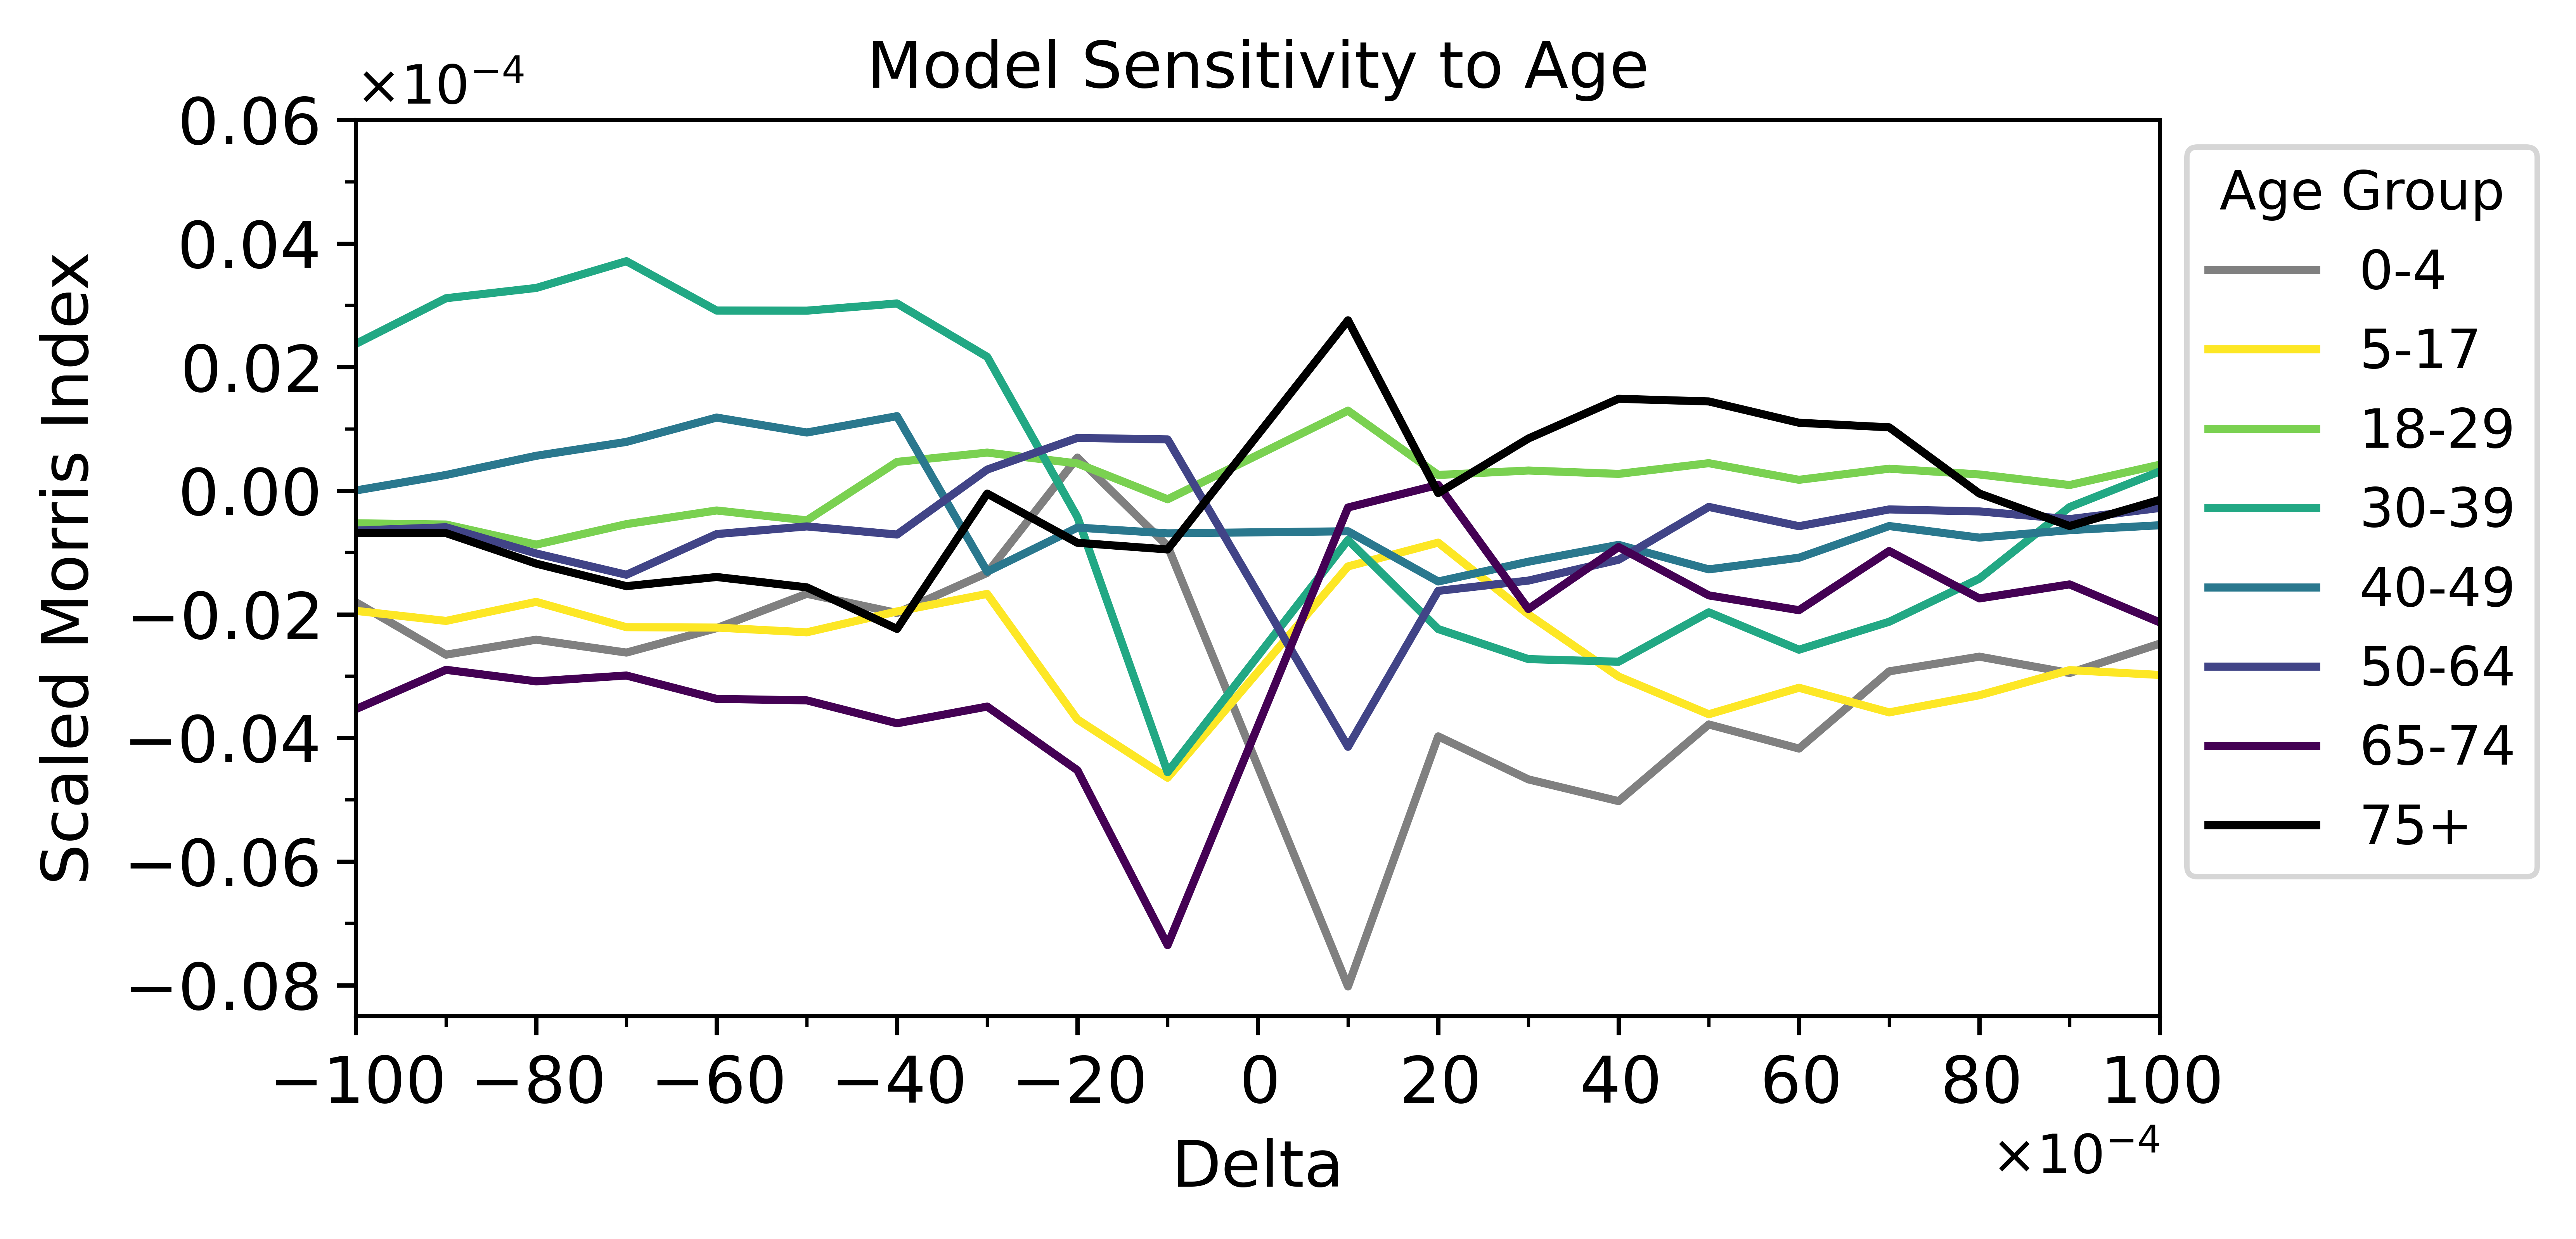

In [3]:
# Plot
mpl.rcParams['figure.dpi'] = 1000
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', sharey=True, figsize=(6, 3))
label = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75+']
color = ['gray', '#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154', 'black']

# plot the same data on both axes
for i in range(len(ages)):
    plt.plot(age_total[i].Delta, age_total[i].Morris_sensitivity, '-', linewidth=1.5, label=label[i], color=color[i])
    
# Scale axes
ax.yaxis.set_major_formatter(OOMFormatter(-4, "%1.2f"))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))   
ax.xaxis.set_major_formatter(OOMFormatter(-4, "%1.0f"))
ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
ax.xaxis.get_offset_text().set_visible(True)

# Format plot
ax.set_xticks([-0.01 , -0.008, -0.006, -0.004,
               -0.002, 0, 0.002, 0.004, 0.006,
               0.008, 0.01 ])
ax.set_xlim(-0.01, 0.01)
ax.set_ylim(-0.085e-4, 0.06e-4)

# Minor ticks
ax.set_xticks([-90e-4, -70e-4, -50e-4, -30e-4, -10e-4, 10e-4, 30e-4, 50e-4, 70e-4, 90e-4], minor=True)
ax.set_yticks([-0.08e-4, -0.06e-4, -0.04e-4, -0.02e-4, 0, 0.02e-4, 0.04e-4, 0.06e-4], minor=False)
ax.set_yticks([-0.07e-4, -0.05e-4, -0.03e-4, -0.01e-4, 0, 0.01e-4, 0.03e-4, 0.05e-4], minor=True)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add labels
plt.ylabel('Scaled Morris Index', size=12)
plt.xlabel('Delta', size=12)
plt.title('Model Sensitivity to Age', size=12)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Age Group')
plt.savefig('model sensitivity.png', bbox_inches='tight')
plt.show()

# Morris Ranking

In [4]:
# Get delta values
for i in range(0, len(ages)):
    data[i].Delta = round(data[i].Delta, 3)

deltas = list(data[0].Delta.unique())

# Create ranking dataframe
ranking = pd.DataFrame(np.zeros(len(ages)))
ranking = ranking.reindex(index = ['0 - 4 Years','5 - 17 Years','18 - 29 Years', 
                                   '30 - 39 Years', '40 - 49 Years', 
                                   '50 - 64 Years', '65 - 74 Years', '75+ Years'])

# Save values
for j in range(0, 20): 
    one = []
    for i in range(0, len(ages)):
        x = data[i][(data[i]['Delta'] == deltas[j])
                & (data[i]['Feature'] != 'VaccinationFull')]['Morris_sensitivity']
        one.append(x.values[0])
    ranking.insert(j, str(deltas[j]), one, True)
    
ranking = ranking.drop(0, axis=1)

# Show ranking
for i in ranking.columns: 
    ranking[i] = ranking[i].rank(ascending=True)
ranking['mean_rows'] = ranking.mean(axis = 1)
result = ranking[['mean_rows']]

In [5]:
result.style.background_gradient('Blues', subset=['mean_rows'])\
       .format({'mean_rows': '{:.5f}'})

,mean_rows
0 - 4 Years,2.25000
5 - 17 Years,2.40000
18 - 29 Years,6.80000
30 - 39 Years,5.50000
40 - 49 Years,5.60000
50 - 64 Years,5.30000
65 - 74 Years,2.65000
75+ Years,5.50000


In [6]:
result = result.rename(columns={'mean_rows': 'Morris'}).rank(ascending=True)
result.style.background_gradient('Blues', subset=['Morris'])\
       .format({'Morris': '{:.0f}'})

,Morris
0 - 4 Years,1
5 - 17 Years,2
18 - 29 Years,8
30 - 39 Years,6
40 - 49 Years,7
50 - 64 Years,4
65 - 74 Years,3
75+ Years,6


# Ground Truth

## Cases by Age
https://data.cdc.gov/Public-Health-Surveillance/COVID-19-Weekly-Cases-and-Deaths-by-Age-Race-Ethni/hrdz-jaxc

### Preprocess

In [7]:
data = pd.read_csv('Ground Truth/COVID-19_Weekly_Cases_and_Deaths_by_Age__Race_Ethnicity__and_Sex.csv')

# Select all U.S. jurisdictions, age groups, sexes, races/ethnicities
data = data[data.jurisdiction == 'US']
data = data[data.age_group != 'Overall']
data = data[data.sex == 'Overall']
data = data[data.race_ethnicity_combined == 'Overall']
data.drop(columns=[
    'jurisdiction', 'sex', 'race_ethnicity_combined',
    'deaths', 'death_rate_per_100k', 'case_rate_per_100k'
], inplace=True)

In [8]:
# Convert end_of_week column to DateTime
data['end_of_week'] = pd.to_datetime(data['end_of_week'])
data = data.sort_values(by=['end_of_week', 'age_group'])
data = data.reset_index().drop(columns=['index'])

In [9]:
# since it is cumulative weekly report, count started from 6 days early
first_date = data['end_of_week'].min() - pd.to_timedelta(6, unit='D')
start_df = pd.DataFrame({'age_group':data['age_group'].unique()})

start_df['end_of_week'] = first_date
start_df['cases'] = 0
data = pd.concat([start_df, data])

In [10]:
# Select date range (end_of_week = 3/1/2020 to end_of_week = 12/27/2021)
start = max(pd.to_datetime('2020-03-01'), first_date)
end = pd.to_datetime('2021-11-27')
print(f'Whole data contains period {start} to {end}.')

data = data[(data['end_of_week']>=start) & (data['end_of_week']<=end)]

Whole data contains period 2020-03-01 00:00:00 to 2021-11-27 00:00:00.


In [11]:
# combine the second to fourth groups into a single one to  
# align with the county age distribution groups
age_5_17 = data[
    data['age_group'].isin(
        ['end_of_week', '5 - 11 Years', '12 - 15 Years', '16 - 17 Years']
    )
].groupby('end_of_week').aggregate('sum', numeric_only=True).reset_index()
age_5_17['age_group'] = '5 - 17 Years'

In [12]:
# drop the combined groups 
data = data[~data['age_group'].isin(['5 - 11 Years', '12 - 15 Years', '16 - 17 Years'])]

data = pd.concat([data, age_5_17]).reset_index(drop=True)

### Plot

In [153]:
from Class.PlotConfig import *

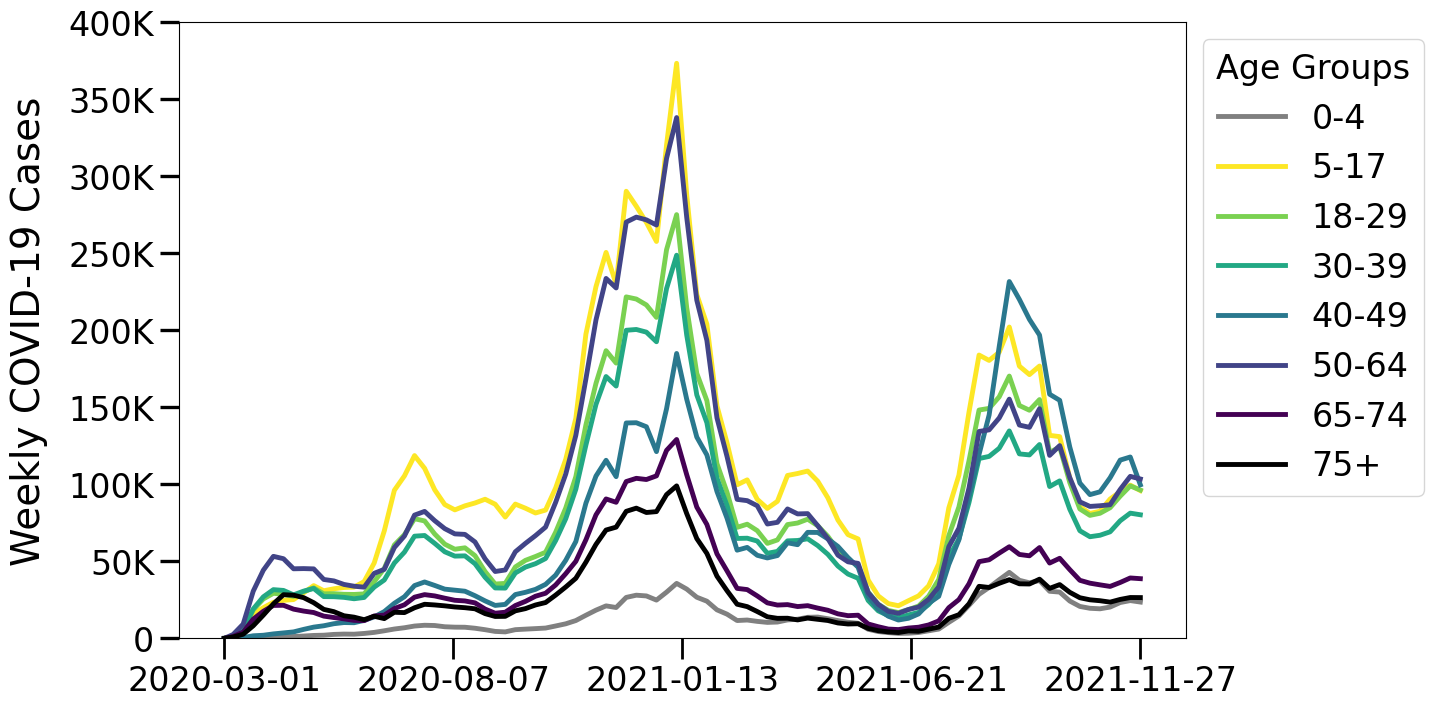

In [170]:
fig, ax = plt.subplots(figsize=(13, 8))
colors = ['gray', '#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154', 'black']
labels = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75+']

for index, (age_group, age_data) in enumerate(data.groupby('age_group')):
    ax.plot(
        age_data['end_of_week'], age_data['cases'], 
        color=colors[index], label=labels[index],
        linewidth=3.5 
        # marker=markers[index], markersize=8
    )

label_text = [] 
for loc in ax.get_yticks():
    if loc == 0:
        label_text.append('0')
    else:
        label_text.append(f'{loc/1e3:0.5g}K') 

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(label_text)
ax.set_ylim(0)

x_first_tick = data['end_of_week'].min()
x_last_tick = data['end_of_week'].max()
x_major_ticks = 5
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)

plt.ylabel(f'Weekly COVID-19 Cases', labelpad=15)
# plt.title('Weekly COVID-19 Cases by Age Group', size=12)

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Age Groups')

plt.savefig('weekly_ground_truth.jpg', bbox_inches='tight', dpi=200)
# plt.show()

### Plot (old)

In [ ]:
# # Prepare data for plotting
# x = data.end_of_week.unique()
# y1 = data[data.age_group == '0 - 4 Years'].cases
# y2 = data[data.age_group == '5 - 17 Years'].cases
# y3 = data[data.age_group == '18 - 29 Years'].cases
# y4 = data[data.age_group == '30 - 39 Years'].cases
# y5 = data[data.age_group == '40 - 49 Years'].cases
# y6 = data[data.age_group == '50 - 64 Years'].cases
# y7 = data[data.age_group == '65 - 74 Years'].cases
# y8 = data[data.age_group == '75+ Years'].cases

In [ ]:
# mpl.rcParams['figure.dpi'] = 1000
# fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', sharey=True, figsize=(6, 3))

# # Plot 
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
# color = ['gray', '#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154', 'black']
# label = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75+']
# plt.plot(x, y1, color = color[0], label=label[0])
# plt.plot(x, y2, color = color[1], label=label[1])
# plt.plot(x, y3, color = color[2], label=label[2])
# plt.plot(x, y4, color = color[3], label=label[3])
# plt.plot(x, y5, color = color[4], label=label[4])
# plt.plot(x, y6, color = color[5], label=label[5])
# plt.plot(x, y7, color = color[6], label=label[6])
# plt.plot(x, y8, color = color[7], label=label[7])

# # Format axis 
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# ax.figure.autofmt_xdate(rotation=0, ha='center');
# ax.tick_params(labelsize=12, which='both')

# # Format labels
# ax.yaxis.set_major_formatter(OOMFormatter(3, "%5.0f"))
# ax.ticklabel_format(axis='y', style='sci')   
# ax.set_yticks([50e3, 100e3, 150e3, 200e3, 250e3, 300e3, 350e3], minor=True)
# ax.set_xlim('2020-03-07T00:00:00.000000000', '2021-11-27T00:00:00.000000000')
# ax.set_ylim(0, 400e3)

# for label in ax.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)

# # Add labels
# plt.ylabel('COVID-19 Cases', size=12)
# plt.xlabel('Date', size=12)
# plt.title('Weekly COVID-19 Cases by Age Group', size=12)
# plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Age Group')
# plt.savefig('fig2.png', bbox_inches='tight')
# plt.show()

### Aggregate

In [13]:
# Find sum of all cases for each age group during time period
data = data.groupby(by=["age_group"]).sum('numeric_only').sort_index()

data

,cases
age_group,
0 - 4 Years,1249223
18 - 29 Years,10018923
30 - 39 Years,7760789
40 - 49 Years,6767348
5 - 17 Years,6184296
50 - 64 Years,8820765
65 - 74 Years,3289094
75+ Years,2505606


In [ ]:
# # fix: uncomment this to fix the index alignment issue later

# data = data.reindex(index = [
#     '0 - 4 Years','5 - 17 Years','18 - 29 Years', 
#     '30 - 39 Years', '40 - 49 Years', 
#     '50 - 64 Years', '65 - 74 Years', '75+ Years'
# ])

## Population by Age
## These data are estimates for April 1, 2020
https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html

In [15]:
# Import data from csv
pop = pd.read_csv('Ground Truth/nc-est2021-agesex-res.csv', usecols=['SEX', 'AGE', 'ESTIMATESBASE2020'])
pop = pop[pop.SEX == 0]
pop = pop.rename(columns={'ESTIMATESBASE2020': 'population', 'AGE': 'age'})
pop = pop.drop(columns=['SEX'])

# Create age groups
age_04 = pop.iloc[0:5].population.values.sum()
age_517 = pop.iloc[5:18].population.values.sum()
age_1829 = pop.iloc[18:30].population.values.sum()
age_3039 = pop.iloc[30:40].population.values.sum()
age_4049 = pop.iloc[40:50].population.values.sum()
age_5064 = pop.iloc[50:65].population.values.sum()
age_6574 = pop.iloc[65:75].population.values.sum()
age_75plus = pop.iloc[75:101].population.values.sum()
pops = [age_04, age_517, age_1829, age_3039, age_4049, age_5064, age_6574, age_75plus]

# 
# Using DataFrame.insert() to add a column
data.insert(1, "Population", pops, True)

# error: this reindexing needs to happen before the column insertion
data = data.reindex(index = [
    '0 - 4 Years','5 - 17 Years','18 - 29 Years', 
    '30 - 39 Years', '40 - 49 Years', 
    '50 - 64 Years', '65 - 74 Years', '75+ Years'
])

data.index.name = 'Age Group'
data = data.rename({'cases': 'Cases'}, axis=1) 

In [16]:
data

,Cases,Population
Age Group,,
0 - 4 Years,1249223,19392551
5 - 17 Years,6184296,41003731
18 - 29 Years,10018923,54992661
30 - 39 Years,7760789,53013409
40 - 49 Years,6767348,45034182
50 - 64 Years,8820765,63876118
65 - 74 Years,3289094,32346340
75+ Years,2505606,21790289


# Ground Truth Ranking

In [17]:
# Calculate percentage of age infected 
percent_group = (data.Cases / data.Population).values * 100
data.insert(2, "Infection Rate (%)", np.round(percent_group, 2), True)

In [18]:
data.reset_index().style\
    .background_gradient('Blues', subset=['Infection Rate (%)'])\
    .format({'Cases': '{:,d}', 'Population': '{:,d}', 'Infection Rate (%)': '{:.1f}', 'Morris': '{:.0f}'})\
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])\
    .set_properties(**{'text-align': 'center'})\
    .hide(axis='index')

Age Group,Cases,Population,Infection Rate (%)
0 - 4 Years,"1,249,223","19,392,551",6.4
5 - 17 Years,"6,184,296","41,003,731",15.1
18 - 29 Years,"10,018,923","54,992,661",18.2
30 - 39 Years,"7,760,789","53,013,409",14.6
40 - 49 Years,"6,767,348","45,034,182",15.0
50 - 64 Years,"8,820,765","63,876,118",13.8
65 - 74 Years,"3,289,094","32,346,340",10.2
75+ Years,"2,505,606","21,790,289",11.5


In [20]:
# Add Morris ranking
morris = result['Morris']
data.insert(3, 'Morris', morris, True)

In [21]:
data.reset_index().style\
    .background_gradient('Blues', subset=['Infection Rate (%)', 'Morris'])\
    .format({'Cases': '{:,d}', 'Population': '{:,d}', 'Infection Rate (%)': '{:.1f}', 'Morris': '{:.0f}'})\
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])\
    .set_properties(**{'text-align': 'center'})\
    .hide(axis='index')

Age Group,Cases,Population,Infection Rate (%),Morris
0 - 4 Years,"1,249,223","19,392,551",6.4,1
5 - 17 Years,"6,184,296","41,003,731",15.1,2
18 - 29 Years,"10,018,923","54,992,661",18.2,8
30 - 39 Years,"7,760,789","53,013,409",14.6,6
40 - 49 Years,"6,767,348","45,034,182",15.0,7
50 - 64 Years,"8,820,765","63,876,118",13.8,4
65 - 74 Years,"3,289,094","32,346,340",10.2,3
75+ Years,"2,505,606","21,790,289",11.5,6


In [22]:
# Add population ranking 
data['Population'] = data['Infection Rate (%)'].rank(ascending=True)
data = data.drop(columns=['Cases', 'Infection Rate (%)'])
ranking[['mean_rows']].style.background_gradient('Blues', subset=['mean_rows'])\
       .format({'mean_rows': '{:.2f}'})
data

# Add difference in ranking 
change = abs(data['Population'] - data['Morris'])
data.insert(2, 'Difference', change, True)

# Change name to true
data = data.rename(columns={'Population': 'True'})

In [29]:
data[['True', 'Morris', 'Difference']].reset_index().style\
    .background_gradient('Blues', subset=['Morris', 'True'])\
    .background_gradient('Reds', subset=['Difference'])\
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])\
    .format({'Morris': '{:.2g}', 'True': '{:.2f}', 'Difference': '{:.2f}'})\
    .set_properties( **{'text-align': 'center'})\
    .hide(axis='index')

Age Group,True,Morris,Difference
0 - 4 Years,1.00,1,0.00
5 - 17 Years,7.00,2,5.00
18 - 29 Years,8.00,8,0.00
30 - 39 Years,5.00,5.5,0.50
40 - 49 Years,6.00,7,1.00
50 - 64 Years,4.00,4,0.00
65 - 74 Years,2.00,3,1.00
75+ Years,3.00,5.5,2.50
